# 0. The problem

### Context

Our client is an Insurance company that has provided Health Insurance to its customers. Now the company needs your help to build a model capable of predict if a policyholder (customers) from past year will also be interested in **Vehicle Insurance**, also provided by the company.

A prediction model will help the company being more accurate in its communication strategy to reach out those customers most likely to purchase a vehicle insurance.

### Solution

Supposing that the company does not have enough resources to contact every client in the data base, a good strategy would be creating a list of clients ordered by their propensity of being interested in Vehicle Insurance. Such strategy would allow the company to maximize the effort of reaching the potential clients in comparison to a randomized choice in a list.

Let's say the company has a marketing budget to contact **25000** person.

The purpose is to employ a Machine Learning model to order a list of clients, from the most interested in to the less one. Next, with that list it is possible to plot a Cumulative Gains Curve to evaluate the effectiveness of the model in comparison to a randomized choice.

# 1. Data description

## 1.1. Imports

In [2]:
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")
#sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import TargetEncoder, StandardScaler

from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, ConfusionMatrixDisplay

import scikitplot as skplt

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

In [2]:
# Random seed
seed = 42

In [3]:
# Functions
def some_metrics(y_pred, y_true):
    accuracy = accuracy_score(y_pred=y_pred, y_true=y_true)
    precision = precision_score(y_pred=y_pred, y_true=y_true)
    recall = recall_score(y_pred=y_pred, y_true=y_true)
    f1 = f1_score(y_pred=y_pred, y_true=y_true)
    print(f'Accuracy: {100*accuracy:.4f}%')
    print(f'Precision: {100*precision:.4f}%')
    print(f'Recall: {100*recall:.4f}%')
    print(f'F1 score: {f1:.4f}')

## 1.2. Loading data

Data available at https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction

In [4]:
PATH = '../data/raw/train.csv'

df_raw = pd.read_csv(filepath_or_buffer=PATH)
df = df_raw.copy()

# 2. Exploratory Data Analysis (EDA)

## 2.1. Data description

In [5]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


Columns description:

* **id**                      Unique ID for the customer  
* **Gender**                  Gender of the customer  
* **Age**                     Age of the customer  
* **Driving_License**         0 : Customer does not have DL, 1 : Customer already has DL  
* **Region_Code** 	        Unique code for the region of the customer  
* **Previously_Insured**	    1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance  
* **Vehicle_Age** 	        Age of the Vehicle  
* **Vehicle_Damage** 	        1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.  
* **Annual_Premium** 	        The amount customer needs to pay as premium in the year  
* **Policy_Sales_Channel** 	Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.  
* **Vintage** 	            Number of Days which customer has been associated with the company  
* **Response** 	            1 : Customer is interested, 0 : Customer is not interested

* Currency: Idian Rupee (Rs)

#### Shape

In [7]:
print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns: {df.shape[1]}')

Number of rows: 381109
Number of columns: 12


#### Types

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


**Summary**
- Categorical variables:
    - gender (object)
    - driving license (int64)
    - previously insured (int64)
    - region code (float64)
    - policy sales channel (float64)
    - vehicle age (object)
    - vehicle damage (object)
    - response (int64)
- Variable representing numerical variables:
    - age
    - annual premium
    - vintage

#### Missing values
-> No missing values

In [11]:
df.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

#### Duplicated
-> The number of duplicates is low, so they were removed with no further investigation

In [12]:
df.duplicated().sum()

0

#### Split data into train and test

In [14]:
df_train, df_valid = train_test_split(df, train_size=0.7, stratify=df['Response'], random_state=seed)

#### Target variable
-> Unbalanced target

<Axes: xlabel='Response', ylabel='count'>

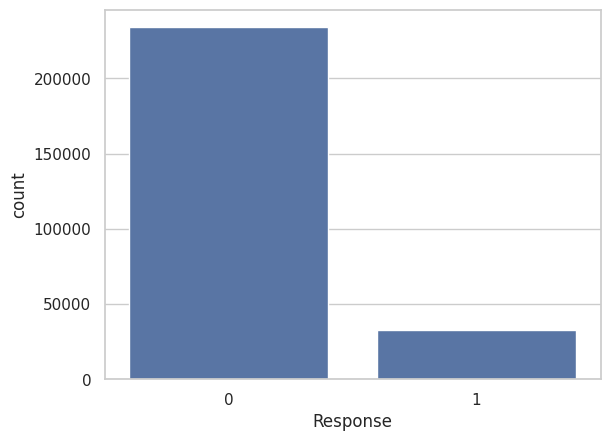

In [15]:
sns.countplot(data=df_train, x=df_train['Response'])

In [16]:
print(f'Total of interested: {df_train["Response"].value_counts(normalize=True)[1]*100:.2f}%')
print(f'Total of not interested: {df_train["Response"].value_counts(normalize=True)[0]*100:.2f}%')

Total of interested: 12.26%
Total of not interested: 87.74%


#### Numerical variables

In [17]:
num_columns = df_train[["Age", "Annual_Premium", "Vintage"]].columns.tolist()
num_columns

['Age', 'Annual_Premium', 'Vintage']

In [18]:
df_train[num_columns].describe()

,Age,Annual_Premium,Vintage
count,266776.000000,266776.000000,266776.000000
mean,38.843389,30597.529234,154.423246
std,15.513232,17234.538416,83.652733
min,20.000000,2630.000000,10.000000
25%,25.000000,24406.000000,82.000000
50%,36.000000,31693.000000,154.000000
75%,49.000000,39448.000000,227.000000
max,85.000000,540165.000000,299.000000


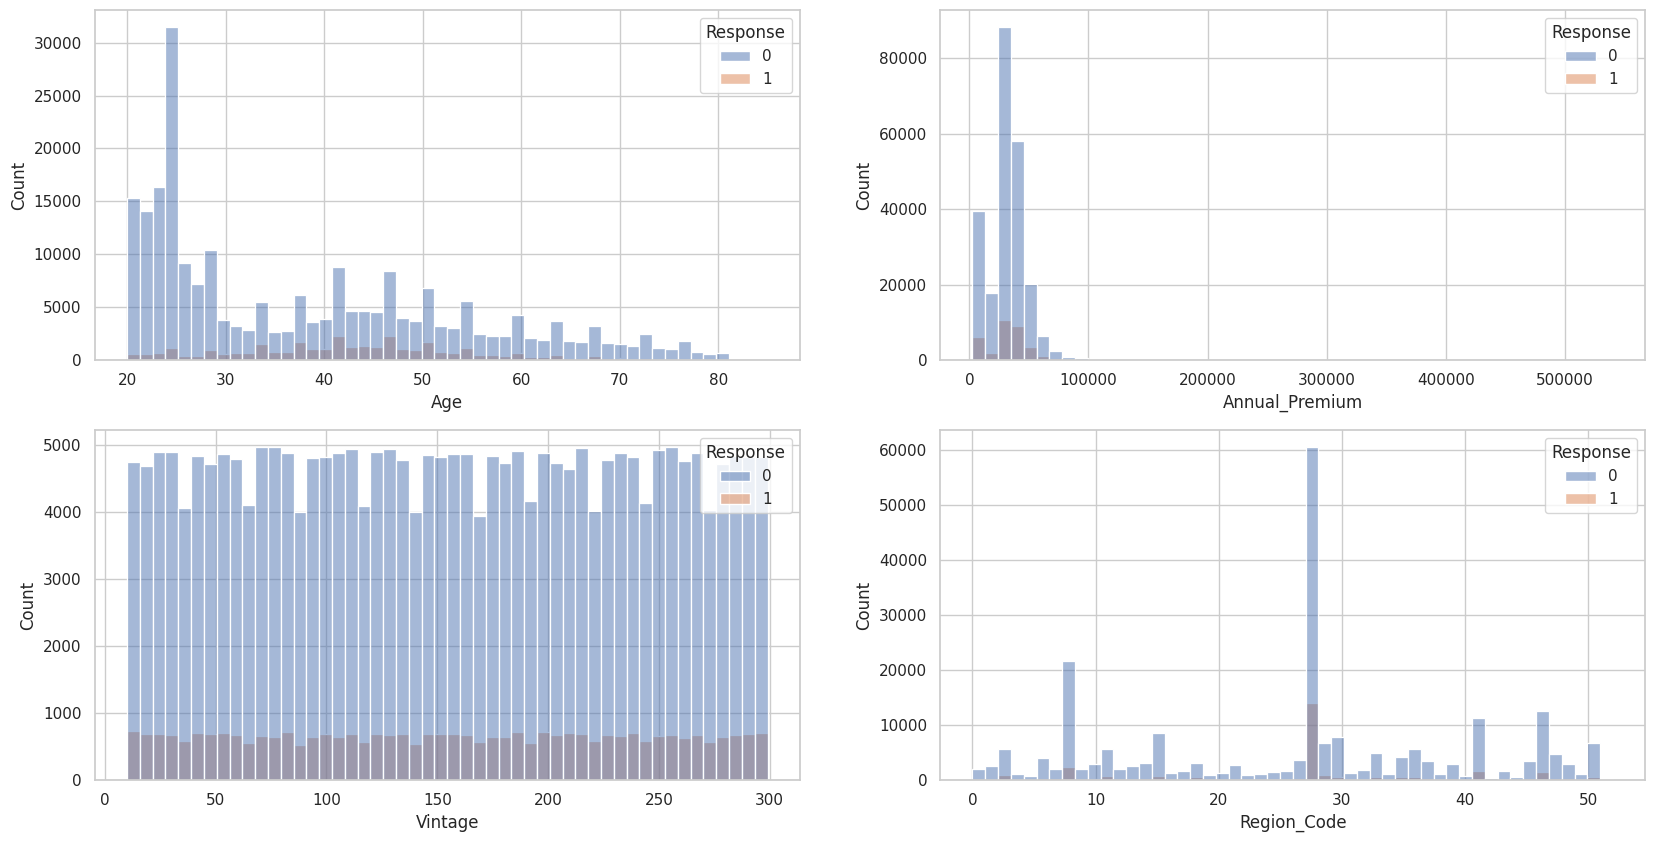

In [19]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
sns.histplot(data=df_train, x='Age', hue='Response', bins=50, ax=ax[0][0])
sns.histplot(data=df_train, x='Annual_Premium', bins=50, hue='Response', ax=ax[0][1])
sns.histplot(data=df_train, x='Vintage', hue='Response', bins=50, ax=ax[1][0])
sns.histplot(data=df_train, x='Region_Code', hue='Response', bins=50, ax=ax[1][1]);

#### Categorical variables

In [20]:
cat_columns = df_train.drop(columns=num_columns).columns.tolist()
cat_columns.pop(0)
cat_columns

['Gender',
 'Driving_License',
 'Region_Code',
 'Previously_Insured',
 'Vehicle_Age',
 'Vehicle_Damage',
 'Policy_Sales_Channel',
 'Response']

<Axes: xlabel='Driving_License', ylabel='count'>

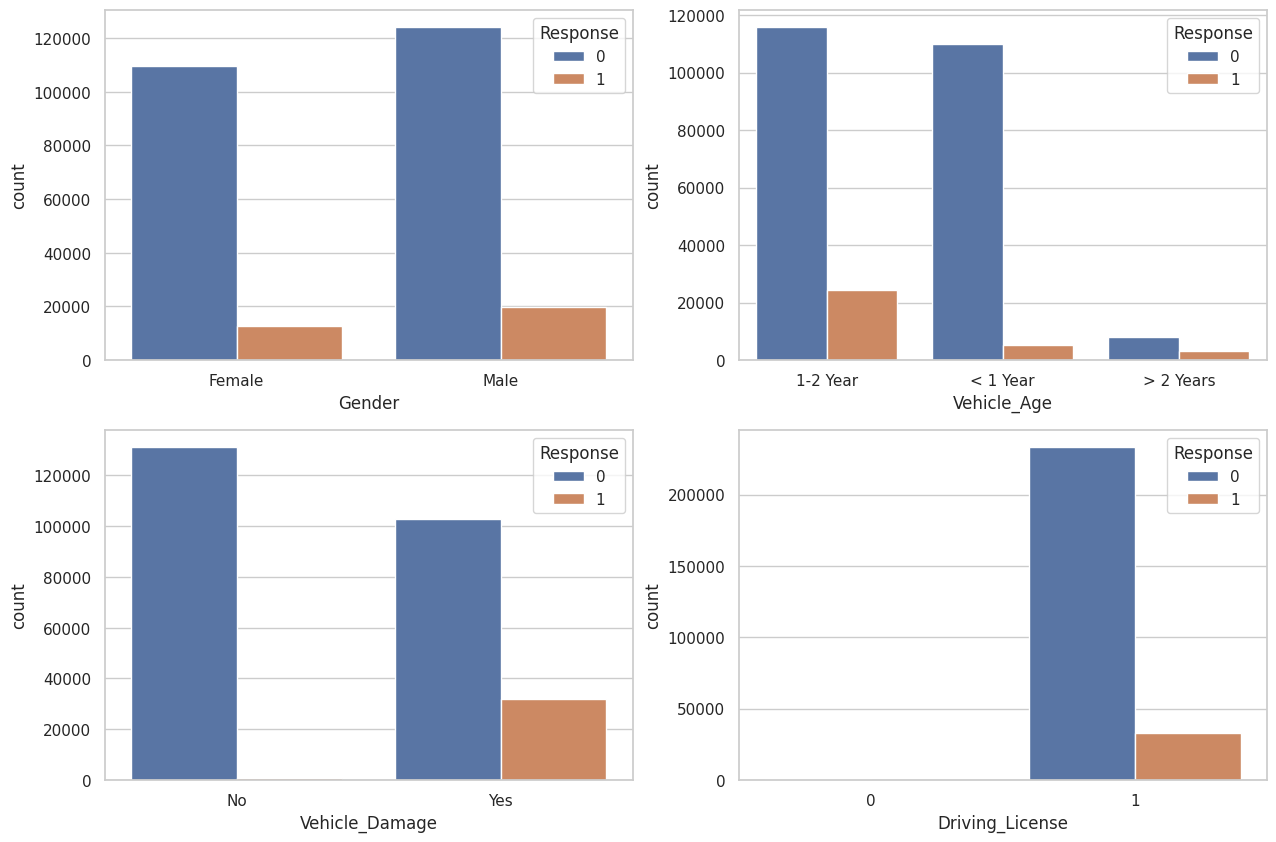

In [21]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
sns.countplot(data=df_train, x='Gender', hue='Response', ax=ax[0][0])
sns.countplot(data=df_train, x='Vehicle_Age', hue='Response', ax=ax[0][1])
sns.countplot(data=df_train, x='Vehicle_Damage', hue='Response', ax=ax[1][0])
sns.countplot(data=df_train, x='Driving_License', hue='Response', ax=ax[1][1])

## 2.2. Hypothesis

#### **H1**: Individuals between 30 and 50 years old would be more likely to purchase a vehicle insurance.
-> True

In [22]:
between_30_50 = df_train.query('Age >= 30 & Age <= 50 & Response == 1').shape[0]
below_30 = df_train.query('Age < 30 and Response == 1').shape[0]
over_50 = df_train.query('Age > 50 and Response == 1').shape[0]

In [23]:
aux1 = pd.DataFrame({'below_30': [below_30],
                     'between_30_50': [between_30_50],
                     'over_50': [over_50]})
aux1

,below_30,between_30_50,over_50
0,4478,19919,8300


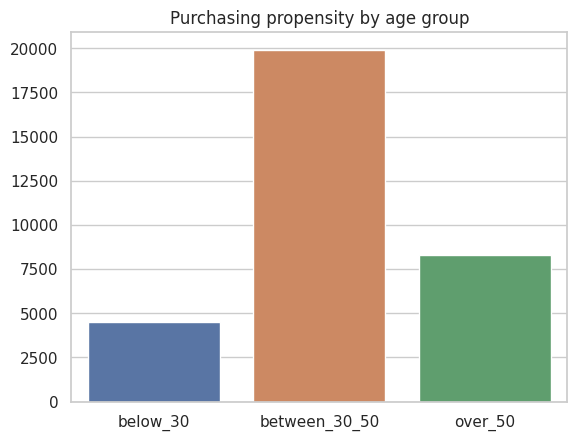

In [24]:
sns.barplot(data=aux1)
plt.title('Purchasing propensity by age group');

#### **H2**: Women would be more interested in having vehicle insurance.
-> False. 10,4% of total women would purchase compared to 13,8% of total men.

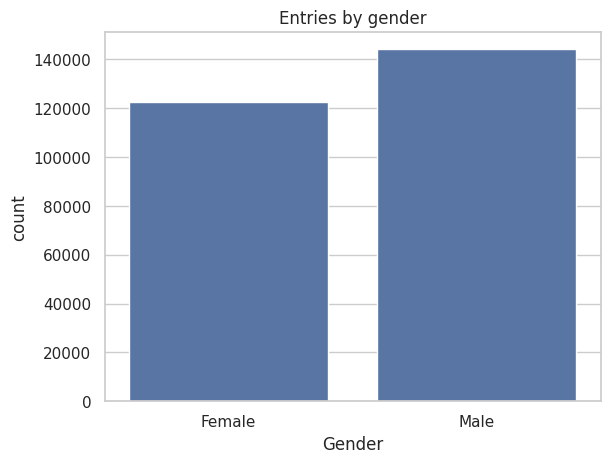

In [25]:
sns.countplot(data=df_train, x='Gender')
plt.title('Entries by gender');

In [26]:
# Result given in proportion by gender
gender_count = pd.crosstab(df_train['Response'], df_train['Gender'], normalize='columns')
gender_count

Gender,Female,Male
Response,,
0,0.895467,0.862104
1,0.104533,0.137896


Text(0.5, 1.0, 'Interest by gender')

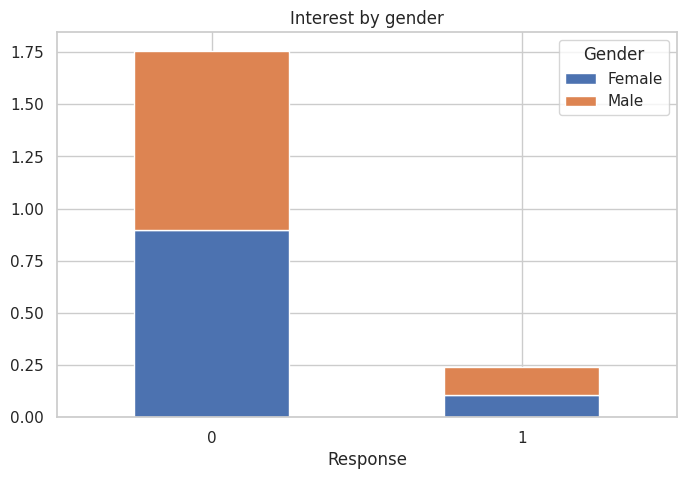

In [27]:
fig, ax = plt.subplots(figsize=(8,5))
gender_count.plot(kind='bar', stacked=True, ax=ax)
plt.xticks(rotation=0)
plt.title('Interest by gender')

#### **H3**: Individuals who already have driver license and got the vehicle damage in the past would be more interested in vehicle insurance.
-> False.

In [28]:
aux3 = df_train.query('Driving_License == 1 & Vehicle_Damage == "Yes"')['Response'].value_counts()

Text(0.5, 1.0, 'Purchasing propensity among people who Driving_License = 1 and Vehicle_Damage = Yes')

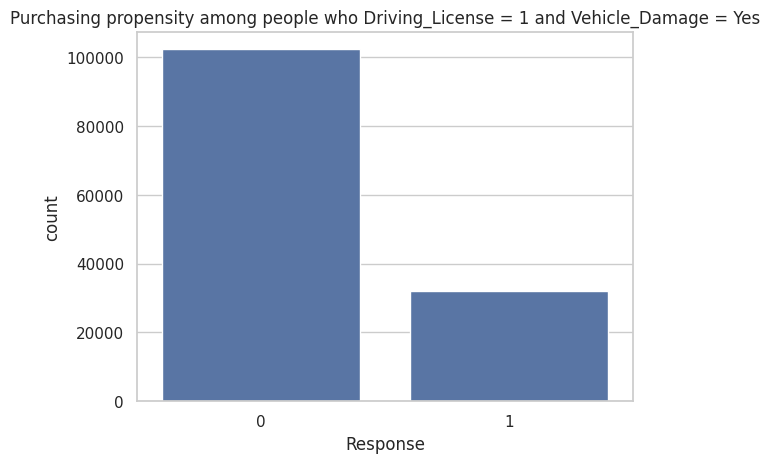

In [29]:
sns.barplot(data=aux3)
plt.title('Purchasing propensity among people who Driving_License = 1 and Vehicle_Damage = Yes')

#### **H4**: Individuals who already have vehicle insurance (previously insured) would not be interested in vehicle insurance.
-> True. 99,91% of those who already have insurance would not purchase another one

In [30]:
pd.crosstab(index=df_train['Response'], columns=df_train['Previously_Insured'], normalize='columns')

Previously_Insured,0,1
Response,,
0,0.774536,0.9991
1,0.225464,0.0009


#### **H5**: Individuals who got the vehicle damaged and were not previously insured would be more interested in vehicle insurance.
-> False. Even if not being insured, people who have vehicle damaged would not purschase

<Axes: xlabel='Response', ylabel='count'>

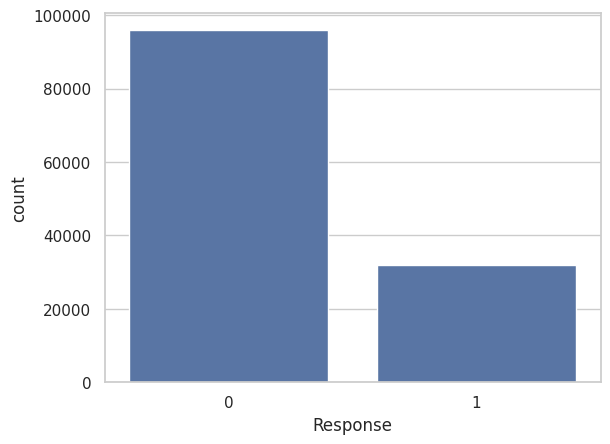

In [31]:
aux5 = df_train.query('Vehicle_Damage == "Yes" & Previously_Insured == 0')['Response'].value_counts()
sns.barplot(data=aux5)

#### **H6**: Individuals who own vehicle with more than two year would be more interested in vehicle insurance.
-> FALSE. Ownners of vehicles between 1-2 years are the most interested.

In [32]:
aux7 = pd.crosstab(index=df['Response'], columns=df['Vehicle_Age'])
aux7

Vehicle_Age,1-2 Year,< 1 Year,> 2 Years
Response,,,
0,165510,157584,11305
1,34806,7202,4702


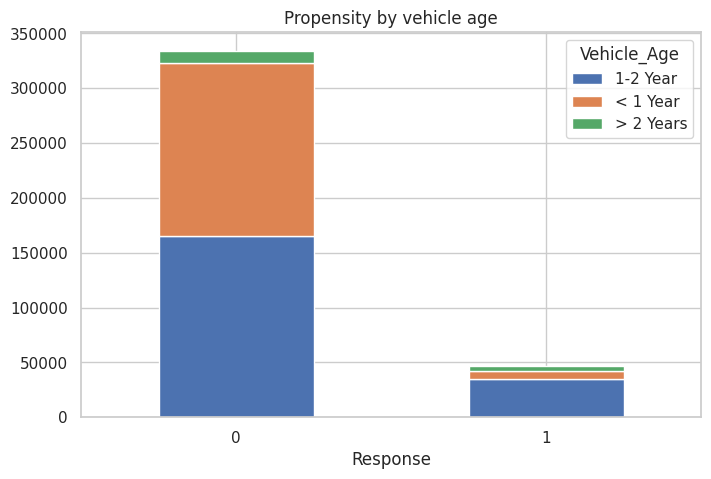

In [33]:
fig, ax = plt.subplots(figsize=(8,5))
aux7.plot(kind='bar', stacked=True, ax=ax)
plt.xticks(rotation=0)
plt.title('Propensity by vehicle age');

<Axes: xlabel='Vehicle_Damage', ylabel='count'>

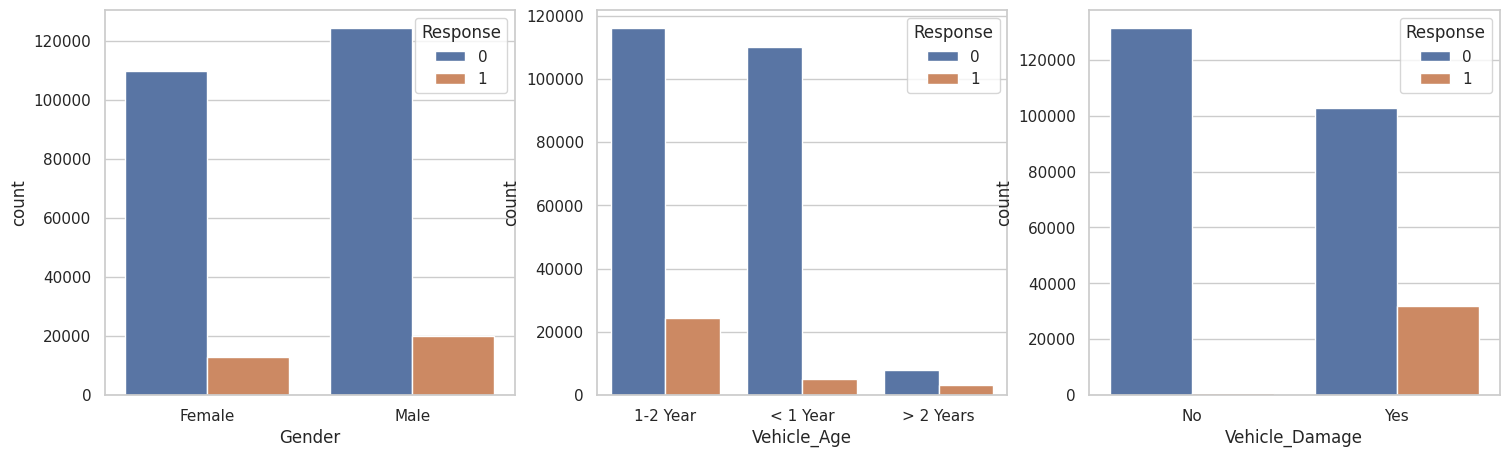

In [34]:
fig, ax = plt.subplots(1,3, figsize=(18,5))
sns.countplot(data=df_train, x=df_train['Gender'], hue=df_train['Response'], ax=ax[0])
sns.countplot(data=df_train, x=df_train['Vehicle_Age'], hue=df_train['Response'], ax=ax[1])
sns.countplot(data=df_train, x=df_train['Vehicle_Damage'], hue=df_train['Response'], ax=ax[2])

#### Vehicle Damage = No --> almost everybody is not interested 

#### Policy sales channel

In [35]:
aux = df_train.groupby('Policy_Sales_Channel')['Response'].sum().reset_index()
aux

,Policy_Sales_Channel,Response
0,1.0,19
1,2.0,1
2,3.0,110
3,4.0,76
4,6.0,0
...,...,...
148,157.0,1274
149,158.0,93
150,159.0,1
151,160.0,325


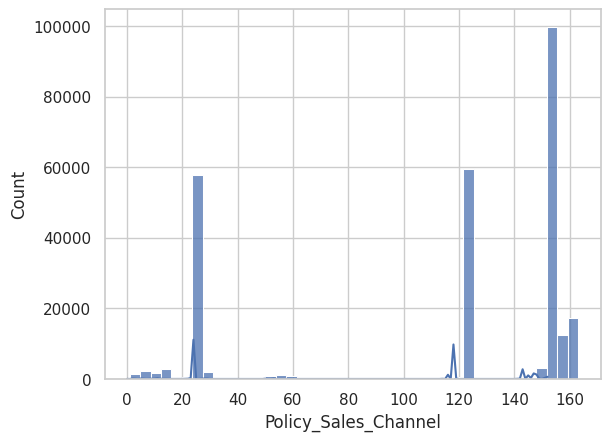

In [36]:
plt.figure()
ax = sns.histplot(data=df_train, x='Policy_Sales_Channel')
ax = plt.plot(aux['Response'])

# 3. Feature Engineering

In [37]:
df_train

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
223531,223532,Female,46,1,23.0,1,1-2 Year,No,34564.0,26.0,71,0
337977,337978,Male,51,1,28.0,1,1-2 Year,No,31982.0,26.0,76,0
320307,320308,Female,40,1,33.0,0,1-2 Year,No,2630.0,12.0,276,0
261303,261304,Female,28,1,4.0,1,< 1 Year,No,2630.0,152.0,223,0
71160,71161,Female,21,1,37.0,1,< 1 Year,No,30939.0,160.0,38,0
...,...,...,...,...,...,...,...,...,...,...,...,...
149107,149108,Male,21,1,15.0,0,< 1 Year,Yes,48284.0,160.0,70,0
378816,378817,Male,25,1,47.0,1,< 1 Year,Yes,23010.0,160.0,58,0
91744,91745,Male,24,1,28.0,0,< 1 Year,No,59094.0,152.0,62,0
48700,48701,Female,40,1,8.0,1,1-2 Year,No,28940.0,26.0,262,0


## 3.1. Data preparation

In [38]:
# Transform vehicle_damage to binary
df_train['Vehicle_Damage'] = df_train['Vehicle_Damage'].apply(lambda x: 0 if x=='No' else 1)

In [39]:
# Mapping gender --> Male:0, Female:1
gender_map = {"Male": 0, "Female": 1}
df_train["Gender"] = df_train["Gender"].map(gender_map)

In [40]:
# Rewrite vehicle age

age_dict = {'< 1 Year': 1,
            '1-2 Year': 2,
            '> 2 Years': 3}

df_train['Vehicle_Age'] = df_train['Vehicle_Age'].map(age_dict)

In [41]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 266776 entries, 223531 to 221791
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    266776 non-null  int64  
 1   Gender                266776 non-null  int64  
 2   Age                   266776 non-null  int64  
 3   Driving_License       266776 non-null  int64  
 4   Region_Code           266776 non-null  float64
 5   Previously_Insured    266776 non-null  int64  
 6   Vehicle_Age           266776 non-null  int64  
 7   Vehicle_Damage        266776 non-null  int64  
 8   Annual_Premium        266776 non-null  float64
 9   Policy_Sales_Channel  266776 non-null  float64
 10  Vintage               266776 non-null  int64  
 11  Response              266776 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 26.5 MB


In [42]:
# Transform type of some categorical features
df_train["Gender"] = df_train["Gender"].astype("category")
df_train['Driving_License'] = df_train['Driving_License'].astype('category')
df_train['Previously_Insured'] = df_train['Previously_Insured'].astype('category')
df_train["Vehicle_Damage"] = df_train["Vehicle_Damage"].astype("category")
df_train['Region_Code'] = df_train['Region_Code'].astype('category')
df_train['Policy_Sales_Channel'] = df_train['Policy_Sales_Channel'].astype('category')
df_train["Response"] = df_train["Response"].astype("category")

In [43]:
X_train = df_train.drop(columns="Response").copy()

y_train = df_train['Response']

print(f'Training dataframe shape: {df_train.shape}')

Training dataframe shape: (266776, 12)


In [44]:
X_train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
223531,223532,1,46,1,23.0,1,2,0,34564.0,26.0,71
337977,337978,0,51,1,28.0,1,2,0,31982.0,26.0,76
320307,320308,1,40,1,33.0,0,2,0,2630.0,12.0,276
261303,261304,1,28,1,4.0,1,1,0,2630.0,152.0,223
71160,71161,1,21,1,37.0,1,1,0,30939.0,160.0,38


In [45]:
# Make column names lowercase
X_train.columns = X_train.columns.str.lower()

y_train.name = y_train.name.lower()

In [46]:
num_columns = X_train.select_dtypes(exclude=['object', 'category']).columns.to_list()
cat_columns = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

In [47]:
num_columns

['id', 'age', 'vehicle_age', 'annual_premium', 'vintage']

In [48]:
cat_columns

['gender',
 'driving_license',
 'region_code',
 'previously_insured',
 'vehicle_damage',
 'policy_sales_channel']

In [49]:
X_train.nunique()

id                      266776
gender                       2
age                         66
driving_license              2
region_code                 53
previously_insured           2
vehicle_age                  3
vehicle_damage               2
annual_premium           44991
policy_sales_channel       153
vintage                    290
dtype: int64

In [50]:
#df_train.dropna(inplace=True)
#df_train.drop_duplicates(inplace=True)

## 3.2. Encoding

### Target encode

In [57]:
# Region code
tar_enc_reg_code = TargetEncoder()
X_train['region_code'] = tar_enc_reg_code.fit_transform(X=X_train[['region_code']], y=y_train)

In [58]:
# Policy sales channel
tar_enc_pol_sales = TargetEncoder()
X_train['policy_sales_channel'] = tar_enc_pol_sales.fit_transform(X=X_train[['policy_sales_channel']], y=y_train)

In [59]:
X_train

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage
223531,223532,1,46,1,0.147742,1,2,0,34564.0,0.199944,71
337977,337978,0,51,1,0.186773,1,2,0,31982.0,0.198770,76
320307,320308,1,40,1,0.096154,0,2,0,2630.0,0.162781,276
261303,261304,1,28,1,0.149473,1,1,0,2630.0,0.029146,223
71160,71161,1,21,1,0.078492,1,1,0,30939.0,0.021184,38
...,...,...,...,...,...,...,...,...,...,...,...
149107,149108,0,21,1,0.076230,0,1,1,48284.0,0.021714,70
378816,378817,0,25,1,0.087811,1,1,1,23010.0,0.021364,58
91744,91745,0,24,1,0.186236,0,1,0,59094.0,0.028773,62
48700,48701,1,40,1,0.096294,1,2,0,28940.0,0.198151,262


## 3.3. Rescaling

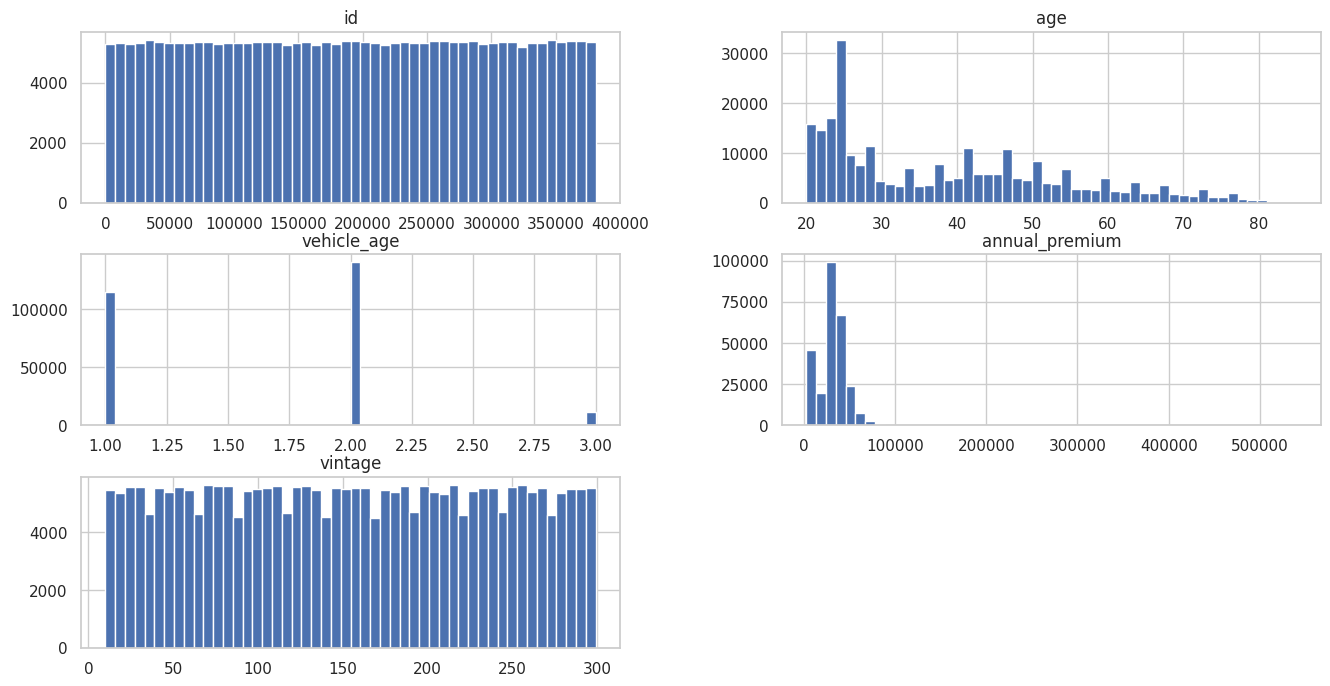

In [60]:
X_train[num_columns].hist(bins=50, figsize=(16,8));

### Vintage - Standard scaler

In [61]:
std_vintage = StandardScaler()

new_vintage = std_vintage.fit_transform(X_train[['vintage']])
X_train['vintage'] = new_vintage

### Age - Standard scaler

In [62]:
std_age = StandardScaler()

new_age = std_age.fit_transform(X_train[['age']])
X_train['age'] = new_age

### Anual premium - Standard scaler, Robust scaler, Box-Cox or Quantile transform

Text(0.5, 1.0, 'Some scalling')

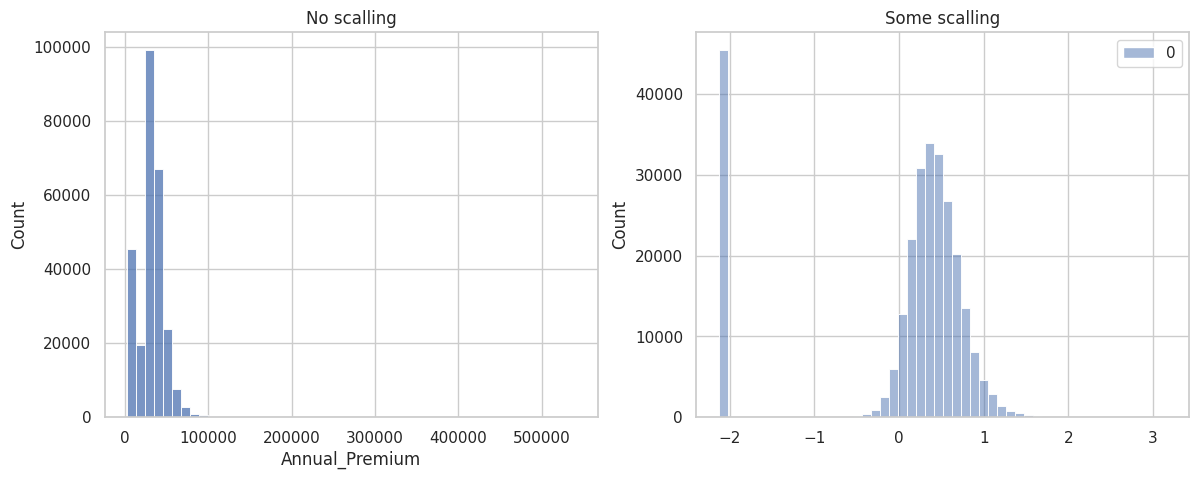

In [63]:
#std_vintage = MinMaxScaler()
std_anual_pr = StandardScaler()
#std_anual_pr = QuantileTransformer()
#std_anual_pr = PowerTransformer(method='box-cox')
#std_anual_pr = RobustScaler()

aux1 = X_train[['annual_premium']].transform(np.log1p)
new_anual_pr = std_anual_pr.fit_transform(aux1)
#new_anual_pr = std_anual_pr.fit_transform(X_train[['annual_premium']])
X_train['annual_premium'] = new_anual_pr

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
sns.histplot(data=df_train['Annual_Premium'], bins=50, ax=ax[0])
sns.histplot(data=new_anual_pr, bins=50, ax=ax[1])
ax[0].set_title('No scalling')
ax[1].set_title('Some scalling')

## 3.4. Preparing validation dataframe

In [64]:
# Transform vehicle_damage to binary
df_valid['Vehicle_Damage'] = df_valid['Vehicle_Damage'].apply(lambda x: 0 if x=='No' else 1)

# Mapping gender --> Male:0, Female:1
gender_map = {"Male": 0, "Female": 1}
df_valid["Gender"] = df_valid["Gender"].map(gender_map)

# Rewrite vehicle age
age_dict = {'< 1 Year': 1,
            '1-2 Year': 2,
            '> 2 Years': 3}
df_valid['Vehicle_Age'] = df_valid['Vehicle_Age'].map(age_dict)

# Transform type of some categorical features
df_valid["Gender"] = df_valid["Gender"].astype("category")
df_valid['Driving_License'] = df_valid['Driving_License'].astype('category')
df_valid['Previously_Insured'] = df_valid['Previously_Insured'].astype('category')
df_valid["Vehicle_Damage"] = df_valid["Vehicle_Damage"].astype("category")
df_valid['Region_Code'] = df_valid['Region_Code'].astype('category')
df_valid['Policy_Sales_Channel'] = df_valid['Policy_Sales_Channel'].astype('category')
df_valid["Response"] = df_valid["Response"].astype("category")

# id column has no importance and can be removed
#df_valid.drop(columns=['id'], inplace=True)
X_valid = df_valid.drop(columns="Response").copy()
y_valid = df_valid['Response']

# Make column names lowercase
X_valid.columns = X_valid.columns.str.lower()
y_valid.name = y_valid.name.lower()

In [65]:
X_valid['region_code'] = tar_enc_reg_code.transform(X=X_valid[['region_code']])

X_valid['policy_sales_channel'] = tar_enc_pol_sales.transform(X=X_valid[['policy_sales_channel']])

In [66]:
X_valid['age'] = std_age.transform(X=X_valid[['age']])

X_valid['vintage'] = std_vintage.transform(X=X_valid[['vintage']])

X_valid['annual_premium'] = std_anual_pr.transform(X=X_valid[['annual_premium']].transform(np.log1p))

In [67]:
X_valid

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage
121404,121405,0,-1.150207,1,0.072945,1,1,0,0.173590,0.029212,-0.148510
355029,355030,1,-0.827901,1,0.074552,0,1,1,-0.001376,0.032256,-1.535198
143332,143333,1,1.041475,1,0.068798,1,2,0,0.302096,0.029212,1.226223
318145,318146,1,0.783630,1,0.123930,1,2,0,0.491316,0.199100,1.489216
94727,94728,1,-1.214668,1,0.074552,0,1,0,0.586443,0.021415,1.118636
...,...,...,...,...,...,...,...,...,...,...,...
182917,182918,0,-0.956823,1,0.079992,0,1,1,0.669049,0.029212,-1.009213
211904,211905,1,1.105936,1,0.186652,0,2,1,0.801246,0.199100,-1.260251
115515,115516,1,0.912552,1,0.186652,0,2,1,-2.128506,0.199100,1.250132
122780,122781,1,-0.634517,1,0.186652,1,1,0,-2.128506,0.029212,1.381628


In [68]:
X_train_no_id = X_train.drop(columns=["id"])
X_valid_no_id = X_valid.drop(columns=["id"])

# 4. Machine Learning Modeling

**Metrics**:
- Caution with accuracy because the target classes are unbalanced. There is much more people who are not interested in car insurence
- It is important to indentify as many customers as possible who are interested in car insurance, even though the model makes some mistakes ==> Recall

## 4.1. Feature selection

In [69]:
# using all features
features = X_train_no_id.columns.to_list()
features

['gender',
 'age',
 'driving_license',
 'region_code',
 'previously_insured',
 'vehicle_age',
 'vehicle_damage',
 'annual_premium',
 'policy_sales_channel',
 'vintage']

## 4.2. Training models

### 4.2.1. Logistic Regression

#### Hyperparameter tunning - Bayesian search

In [70]:
log_reg_clf = LogisticRegression(random_state=seed)

In [71]:
log_reg_space = {
   "C": Real(0.001, 10, prior="log-uniform"),
   "class_weight": [None, "balanced"],
   "solver": ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"] 
}

In [72]:
log_reg_clf_opt = BayesSearchCV(estimator=log_reg_clf, search_spaces=log_reg_space, scoring="recall", cv=5, random_state=seed, n_jobs=-1)
log_reg_clf_opt.fit(X=X_train[features], y=y_train)

/home/ezequiel/.pyenv/versions/car_insurance/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.001, 'balanced', 'lbfgs'] before, using random point [0.042770741591738465, 'balanced', 'sag']
  warnings.warn(
/home/ezequiel/.pyenv/versions/car_insurance/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.001, 'balanced', 'lbfgs'] before, using random point [0.035885534700055004, None, 'newton-cg']
  warnings.warn(
/home/ezequiel/.pyenv/versions/car_insurance/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.001, 'balanced', 'lbfgs'] before, using random point [4.011183343281504, None, 'sag']
  warnings.warn(
/home/ezequiel/.pyenv/versions/car_insurance/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.001, 'bal

BayesSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
              random_state=42, scoring='recall',
              search_spaces={'C': Real(low=0.001, high=10, prior='log-uniform', transform='normalize'),
                             'class_weight': [None, 'balanced'],
                             'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                        'newton-cholesky', 'sag', 'saga']})

In [73]:
log_reg_clf_opt.best_score_

0.9768480156464179

In [74]:
log_reg_clf_opt.best_params_

OrderedDict([('C', 0.001),
             ('class_weight', 'balanced'),
             ('solver', 'liblinear')])

In [75]:
y_pred_log_reg = log_reg_clf_opt.predict(X=X_valid[features])
y_pred_proba_log_reg = log_reg_clf_opt.predict_proba(X=X_valid[features])
roc_log_reg = roc_auc_score(y_score=y_pred_proba_log_reg[:,1], y_true=y_valid)

### 4.2.2. Random Forest

#### Hyperparameter tunning - Bayesian search

In [76]:
rf_clf = RandomForestClassifier(random_state=seed)

In [77]:
rf_space = {
    "n_estimators": Integer(100, 1000),
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": Integer(2, 10),
    "class_weight": [None, "balanced", "balanced_subsample"],
    "max_features": ["sqrt", "log2"],
    "min_impurity_decrease": Real(0.001, 0.1, prior="log-uniform")
}

rf_clf_opt = BayesSearchCV(estimator=rf_clf, search_spaces=rf_space, scoring="recall", cv=5, random_state=seed, n_jobs=-1)

rf_clf_opt.fit(X=X_train[features], y=y_train)

/home/ezequiel/.pyenv/versions/car_insurance/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['balanced_subsample', 'entropy', 2, 'sqrt', 0.1, 100] before, using random point [None, 'log_loss', 10, 'log2', 0.0029853842145220427, 939]
  warnings.warn(
/home/ezequiel/.pyenv/versions/car_insurance/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['balanced', 'entropy', 2, 'sqrt', 0.1, 100] before, using random point [None, 'log_loss', 7, 'log2', 0.0016603735637152077, 268]
  warnings.warn(
/home/ezequiel/.pyenv/versions/car_insurance/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['balanced_subsample', 'entropy', 2, 'sqrt', 0.1, 100] before, using random point [None, 'entropy', 3, 'sqrt', 0.062163427845245874, 914]
  warnings.warn(
/home/ezequiel/.pyenv/versions/car_insurance/lib/py

BayesSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
              n_jobs=-1, random_state=42, scoring='recall',
              search_spaces={'class_weight': [None, 'balanced',
                                              'balanced_subsample'],
                             'criterion': ['gini', 'entropy', 'log_loss'],
                             'max_depth': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'max_features': ['sqrt', 'log2'],
                             'min_impurity_decrease': Real(low=0.001, high=0.1, prior='log-uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=1000, prior='uniform', transform='normalize')})

In [78]:
rf_clf_opt.best_score_

0.9768480156464179

In [79]:
rf_clf_opt.best_params_

OrderedDict([('class_weight', 'balanced'),
             ('criterion', 'log_loss'),
             ('max_depth', 9),
             ('max_features', 'sqrt'),
             ('min_impurity_decrease', 0.021892527128216443),
             ('n_estimators', 473)])

In [80]:
y_pred_rf = rf_clf_opt.predict(X=X_valid[features])
y_pred_proba_rf = rf_clf_opt.predict_proba(X=X_valid[features])
roc_rf = roc_auc_score(y_score=y_pred_proba_rf[:,1], y_true=y_valid)

### 4.2.3. HGBoost

#### Hyperparameter tunning - Bayesian search

In [81]:
hgb_clf = HistGradientBoostingClassifier(categorical_features="from_dtype", random_state=seed)

In [82]:
hgb_space = {
    "learning_rate": Real(0.001, 1, prior="log-uniform"),
    "l2_regularization": Real(0.001, 1, prior="log-uniform"),
    "max_features": Real(0.1, 1),
    "min_samples_leaf": Integer(10, 20),
    "class_weight": [None, "balanced"]
}

hgb_clf_opt = BayesSearchCV(estimator=hgb_clf, search_spaces=hgb_space, scoring="recall", cv=5, random_state=seed, n_jobs=-1)

hgb_clf_opt.fit(X=X_train[features], y=y_train)

BayesSearchCV(cv=5,
              estimator=HistGradientBoostingClassifier(categorical_features='from_dtype',
                                                       random_state=42),
              n_jobs=-1, random_state=42, scoring='recall',
              search_spaces={'class_weight': [None, 'balanced'],
                             'l2_regularization': Real(low=0.001, high=1, prior='log-uniform', transform='normalize'),
                             'learning_rate': Real(low=0.001, high=1, prior='log-uniform', transform='normalize'),
                             'max_features': Real(low=0.1, high=1, prior='uniform', transform='normalize'),
                             'min_samples_leaf': Integer(low=10, high=20, prior='uniform', transform='normalize')})

In [83]:
hgb_clf_opt.best_score_

0.9416458108558716

In [84]:
rf_clf_opt.best_params_

OrderedDict([('class_weight', 'balanced'),
             ('criterion', 'log_loss'),
             ('max_depth', 9),
             ('max_features', 'sqrt'),
             ('min_impurity_decrease', 0.021892527128216443),
             ('n_estimators', 473)])

In [85]:
y_pred_hgb = hgb_clf_opt.predict(X=X_valid[features])
y_pred_proba_hgb = hgb_clf_opt.predict_proba(X=X_valid[features])
roc_hgb = roc_auc_score(y_score=y_pred_proba_hgb[:,1], y_true=y_valid)

### 4.2.4. XGBoost

#### Hyperparameter tunning - Bayesian search

In [86]:
xgb_clf = XGBClassifier(enable_categorical=True, random_state=seed)

##### Bayes search

In [87]:
xgb_space = {
    "n_estimators": Integer(100, 5000),
    "max_depth": Integer(2,10),
    "learning_rate": Real(0.001, 1, prior="log-uniform"),
    "subsample": Real(0.05, 1.0),
    "colsample_bytree": Real(0.1, 1.0),
    #"colsample_bylevel": Real(0.5, 1.0),
    #"colsample_bynode": Real(0.5, 1.0),
    "reg_alpha": Real(0.0, 10.0),
    #"reg_lambda": Real(0.0, 10.0),
    #"gamma": Real(0.0, 10.0)
}

xgb_clf_opt = BayesSearchCV(estimator=xgb_clf, search_spaces=xgb_space, scoring="recall", n_iter=10, cv=5, random_state=seed, n_jobs=-1)

xgb_clf_opt.fit(X=X_train[features], y=y_train)

BayesSearchCV(cv=5,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=True, eval_metric=None,
                                      feature_types=None, gamma=None,
                                      grow_policy=None, importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None,...
                             'learning_rate': Real(low=0.001, high=1, prior='log-uniform', transform='normalize'),
                             'max_depth': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=5000, prior='uniform', transform='normalize'),
                             'reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.05, high=1.0, prior='uniform', transform='normalize')})

In [88]:
# Best roc_auc for training
xgb_clf_opt.best_score_

0.3056546208516953

In [89]:
xgb_clf_opt.best_params_

OrderedDict([('colsample_bytree', 0.5890627609212813),
             ('learning_rate', 0.5754766135782297),
             ('max_depth', 6),
             ('n_estimators', 4205),
             ('reg_alpha', 3.2405998228437367),
             ('subsample', 0.0985778259931992)])

In [90]:
y_pred_xgb = xgb_clf_opt.predict(X=X_valid[features])
y_pred_proba_xgb = xgb_clf_opt.predict_proba(X=X_valid[features])
roc_xgb = roc_auc_score(y_score=y_pred_proba_xgb[:,1], y_true=y_valid)

## 4.3. Results

### 4.3.1. General comparison

In [91]:
def metrics(models):

    results = {'Model': [],
               'Accuracy': [],
               'Precision': [],
               'Recall': [],
               "F1 score": [],
               'ROC_AUC': []}

    for name, pred in models.items():
        results['Model'].append(name)
        results['Accuracy'].append(accuracy_score(y_pred=pred[0], y_true=y_valid))
        results['Precision'].append(precision_score(y_pred=pred[0], y_true=y_valid))
        results['Recall'].append(recall_score(y_pred=pred[0], y_true=y_valid))
        results["F1 score"].append(f1_score(y_pred=pred[0], y_true=y_valid))
        results["ROC_AUC"].append(pred[1])

    results = pd.DataFrame(results).set_index('Model')
    results.index.names = [None]
    return pd.DataFrame(results)

In [92]:
models = {
    'Logistic Regression': [y_pred_log_reg, roc_log_reg],
    "Random Forest": [y_pred_rf, roc_rf],
    "HGBoost": [y_pred_hgb, roc_hgb],
    "XGBoost": [y_pred_xgb, roc_xgb]
    }

results = metrics(models)
results.style.highlight_max(color='green', axis=0)

,Accuracy,Precision,Recall,F1 score,ROC_AUC
Logistic Regression,0.638827,0.250562,0.977806,0.398905,0.836685
Random Forest,0.638836,0.250567,0.977806,0.398911,0.827980
HGBoost,0.684151,0.272892,0.947477,0.423739,0.854024
XGBoost,0.823997,0.294525,0.312496,0.303244,0.799811


#### Confusion matrix

In [93]:
def plot_confusion_matrix(models_list, y_true):
    fig, ax = plt.subplots(1,len(models_list), figsize=(5*len(models_list), 5))
    fig.suptitle('Confusion Matrix')
    n_ax = 0
    for name, pred in models_list.items():
       n_ax = n_ax + 1
       ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=pred[0], ax=ax[n_ax-1], cmap='Blues',colorbar=False)
       ax[n_ax-1].set_title(name)
    for axes in ax.flatten():
        axes.grid(False)    

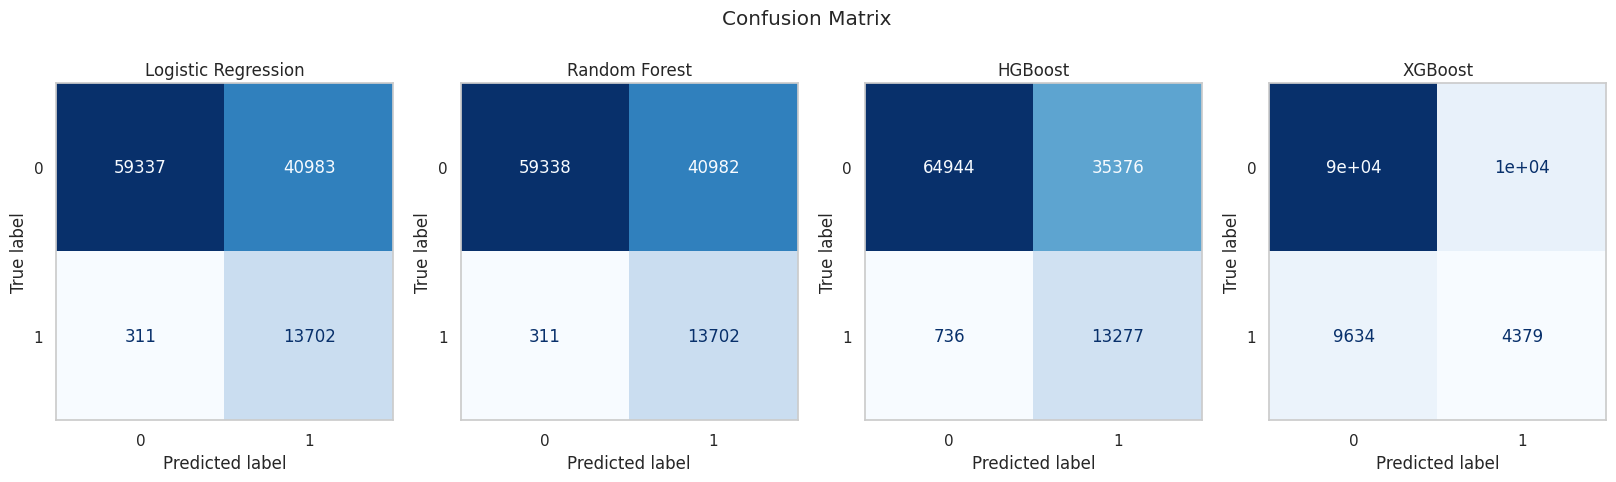

In [94]:
plot_confusion_matrix(models_list=models, y_true=y_valid)

### 4.3.2. Matrics @ K

In [95]:
# Number of customers to be contacted
K = 25000

In [96]:
def propensity_score(y_proba, n_samples):
    aux = pd.concat([X_valid, y_valid], axis=1)
    aux['score'] = y_proba[:, 1].tolist()
    aux = aux.sort_values('score', ascending=False)
    aux = aux[["id", 'response', 'score']].reset_index(drop=True)

    n = n_samples / X_valid.shape[0]      # percentage of data base represented by the number of calls

    print(f'K = {n_samples} represents {n * 100:.2f}% of the validation data base')

    # Precision Top K
    aux['precision_at_k'] = aux['response'].astype(int).cumsum() / (aux.index.values + 1)
    precision_at_k = aux.loc[n_samples, 'precision_at_k']
    print(f'Precision @ K: {precision_at_k * 100:.2f}%')

    # Recall Top K
    aux['recall_at_k'] = aux['response'].astype(int).cumsum() / aux['response'].astype(int).sum()
    recall_at_k = aux.loc[n_samples, 'recall_at_k']
    print(f'Recall @ K: {recall_at_k * 100:.2f}%')

    fig, ax = plt.subplots(1, 2, figsize=(14,5))

    # Gains curve --> Recall (gain) as a function of percentage of sample
    skplt.metrics.plot_cumulative_gain(y_probas=y_proba, y_true=y_valid, ax=ax[0])
    ax[0].vlines(x=n, ymin=0, ymax=recall_at_k, linestyles='dashed', colors='purple')
    ax[0].hlines(y=recall_at_k, xmin=0, xmax=n, linestyles='dashed', colors='purple')
    ax[0].hlines(y=n, xmin=0, xmax=n, linestyles='dashed', colors='purple')

    # Lift curvr --> Lift represents the percentage of customers interested in car insurance as a function of the percentage sample 
    skplt.metrics.plot_lift_curve(y_probas=y_proba, y_true=y_valid, ax=ax[1])
    ax[1].vlines(x=n, ymin=0, ymax=recall_at_k/n, linestyles='dashed', color='purple')
    ax[1].hlines(y=recall_at_k/n, xmin=0, xmax=n, linestyles='dashed', color='purple')
    ax[1].set_xlim(0.05, 1)
    ax[1].set_ylim(0.5, 3.5)

    return aux

K = 25000 represents 21.87% of the validation data base
Precision @ K: 32.23%
Recall @ K: 57.51%


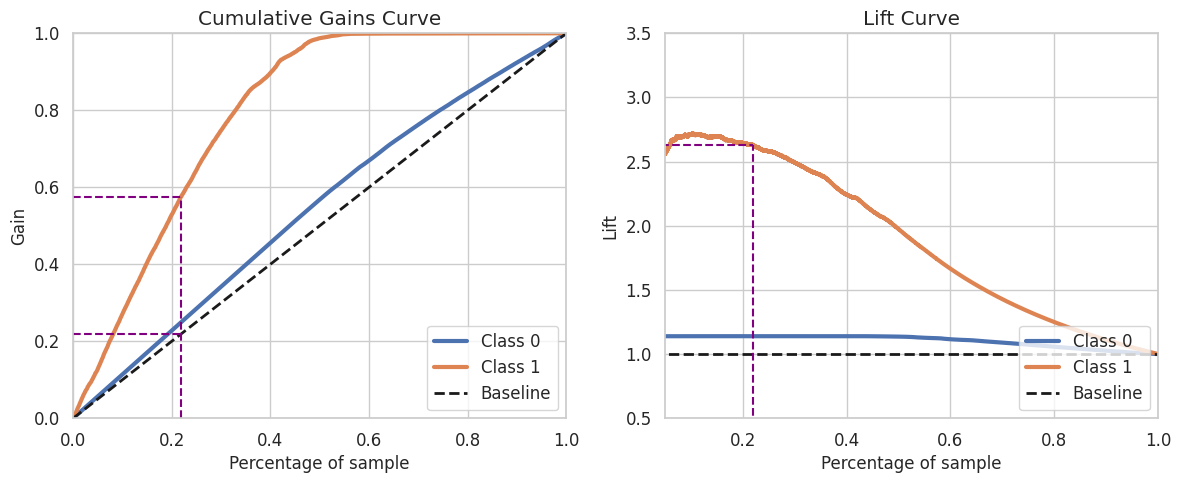

In [97]:
# Logreg
propensity_log_reg = propensity_score(y_proba=y_pred_proba_log_reg, n_samples=K)

K = 25000 represents 21.87% of the validation data base
Precision @ K: 30.33%
Recall @ K: 54.12%


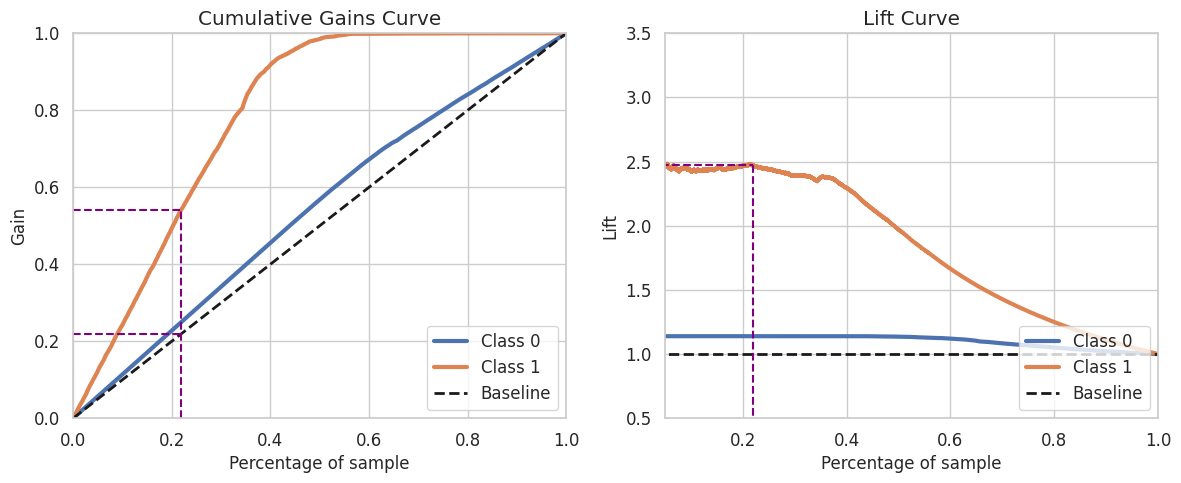

In [98]:
# Random Forest
propensity_rf = propensity_score(y_proba=y_pred_proba_rf, n_samples=K)

K = 25000 represents 21.87% of the validation data base
Precision @ K: 34.58%
Recall @ K: 61.69%


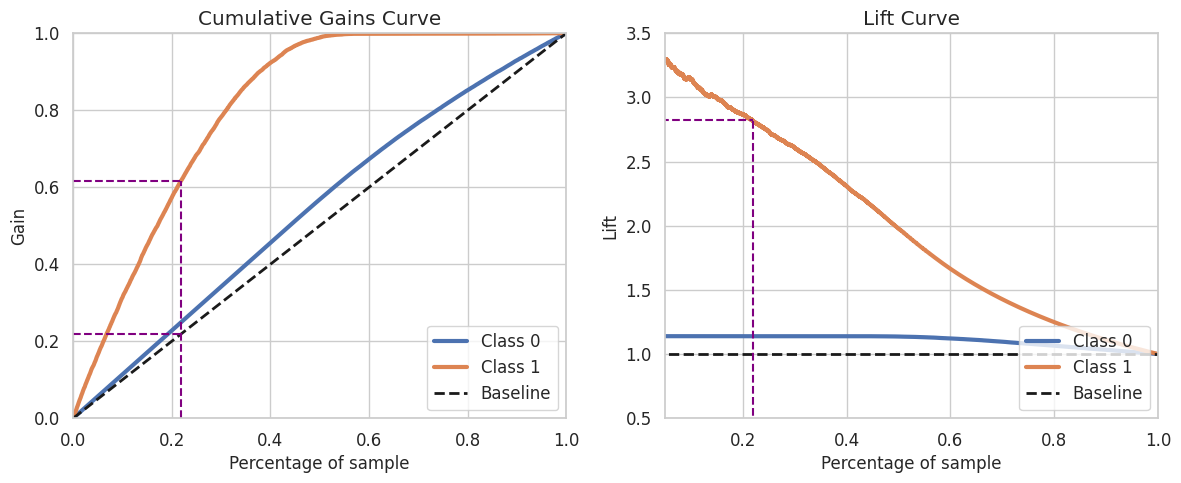

In [99]:
# HGBoost
propensity_hgb = propensity_score(y_proba=y_pred_proba_hgb, n_samples=K)

K = 25000 represents 21.87% of the validation data base
Precision @ K: 28.39%
Recall @ K: 50.65%


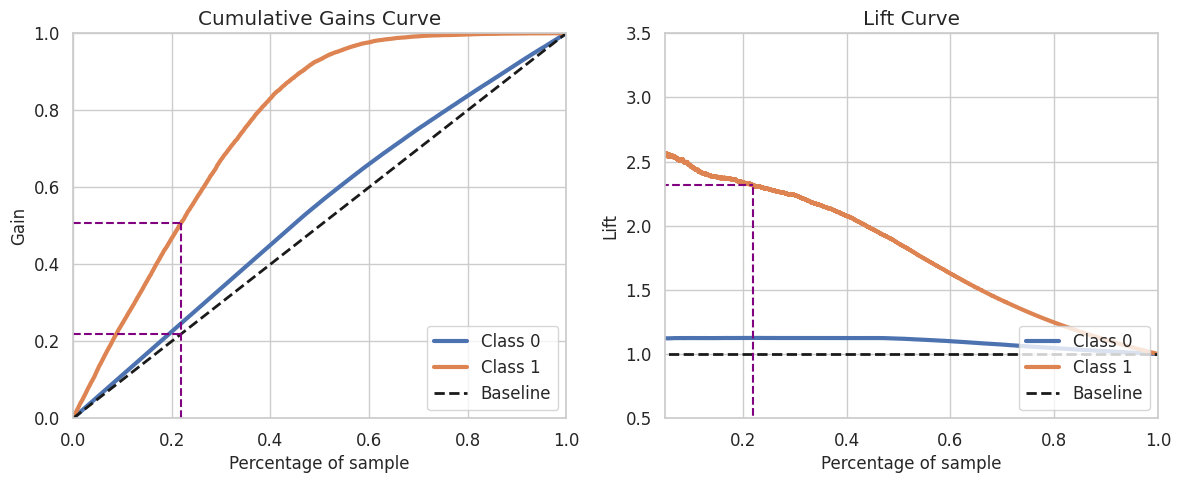

In [100]:
# XGBoost
propensity_xgb = propensity_score(y_proba=y_pred_proba_xgb, n_samples=K)

#### Baseline vs. ML Model

In [101]:
list_of_results = [propensity_log_reg, propensity_rf, propensity_hgb, propensity_xgb]
model_names = list(models.keys())

In [102]:
def baseline_vs_mlmodel(results, n_samples, model_names):
    #total_class_1 = y_valid.value_counts()[1]

    avg_insurance = 1000.00     # hypothetical anual average cost of vehicle insurance in US$
    cost_per_contact = 1.00     # hypothetical cost per contact in US$

    random_recall = n_samples / X_valid.shape[0]
    random_selection = df_valid[["id", "Response"]].sample(n=K)
    total_random = random_selection["Response"].value_counts()[1]
    random_revenue = avg_insurance * total_random
    random_cost = total_random * cost_per_contact

    summary = {
            "Recall @ K": [random_recall],
            'Number of interests': [total_random],
            'Contact per sale': [f'{K / total_random:.2f}'],
            'Cost of contacts (US$)': [random_cost],
            'Revenue (US$)': [random_revenue],
            "Profit (US$):": [random_revenue - random_cost],
            'Gain (%)': ['-']
            }
    
    for result in results:

        total_ml_model = result.iloc[:K, 0:2]["response"].value_counts()[1]
        
        ML_cost = total_ml_model * cost_per_contact
        ML_revenue = avg_insurance * total_ml_model
        recall_at_k = result.loc[n_samples, 'recall_at_k']

        summary["Recall @ K"].append(recall_at_k)
        summary["Number of interests"].append(total_ml_model)
        summary["Contact per sale"].append(np.round(K / total_ml_model, 2))
        summary["Cost of contacts (US$)"].append(ML_cost)
        summary["Revenue (US$)"].append(ML_revenue)
        summary["Profit (US$):"].append(ML_revenue - ML_cost)
        summary["Gain (%)"].append(np.round(((ML_revenue-random_revenue)/random_revenue)*100, 2))

    return pd.DataFrame(index=["Random"]+model_names, data=summary)

In [103]:
comparison = baseline_vs_mlmodel(results=list_of_results, n_samples=K, model_names=model_names)
comparison

,Recall @ K,Number of interests,Contact per sale,Cost of contacts (US$),Revenue (US$),Profit (US$):,Gain (%)
Random,0.218660,2980,8.39,2980.0,2980000.0,2977020.0,-
Logistic Regression,0.575109,8059,3.1,8059.0,8059000.0,8050941.0,170.44
Random Forest,0.541212,7583,3.3,7583.0,7583000.0,7575417.0,154.46
HGBoost,0.616927,8644,2.89,8644.0,8644000.0,8635356.0,190.07
XGBoost,0.506530,7098,3.52,7098.0,7098000.0,7090902.0,138.19


# 5. Conclusion

- The Historic Gradiente Boosting (HGB) model achieved the lowest contact rate per sale (2.89), requiring fewer calls for each successfull sale.
- Using this model, the company achieves an aproximately 190% increase in profit compared to a random selection of customers.
- out of the 25000 contacted customers, the HGB was able to recall approximately 62% of interested, compared to only 22% achieved by a random selection.